In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import scipy as sp
from skimage import transform as skt
import os
import time
import multiprocessing as mp
import skimage.filters as skf
from scipy import ndimage as scnd
import hdf5storage as h5
from matplotlib_scalebar.scalebar import ScaleBar,SI_LENGTH_RECIPROCAL
import math
import ase.build as asb
import ase
import numba
import sys
from ncempy import io as emio
import pyfftw.interfaces as pfi
import pymcr
import stemtool as st
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pco = ase.io.read('/Users/7dm/Desktop/PdCoO2 APL/PdCoO2.cif')
pco.__dict__

{'_cellobj': Cell([[2.86337919, 0.0, 0.0], [-1.4316895949999993, 2.479759119207709, 0.0], [0.0, 0.0, 17.87331404]]),
 'arrays': {'numbers': array([27, 27, 27, 46, 46, 46,  8,  8,  8,  8,  8,  8]),
  'positions': array([[ 1.43169103e+00,  8.26585546e-01,  1.48944224e+01],
         [-1.43168959e-06,  1.65317357e+00,  2.97889163e+00],
         [ 0.00000000e+00,  0.00000000e+00,  8.93665702e+00],
         [-1.43168959e-06,  1.65317357e+00,  1.19155487e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.43169103e+00,  8.26585546e-01,  5.95776539e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.58629952e+01],
         [-1.43168959e-06,  1.65317357e+00,  1.39258675e+01],
         [ 1.43169103e+00,  8.26585546e-01,  3.94744652e+00],
         [ 0.00000000e+00,  0.00000000e+00,  2.01031887e+00],
         [-1.43168959e-06,  1.65317357e+00,  9.90521191e+00],
         [ 1.43169103e+00,  8.26585546e-01,  7.96810213e+00]])},
 '_celldisp': array([[0.],
        [0.],
  

In [4]:
cell_dim = pco._cellobj[0:3]
cell_pos = pco.positions

In [5]:
@numba.jit(parallel=True,cache=True)
def find_uc_pos(atom_pos,cell_dim):
    uc_pos = np.zeros_like(atom_pos)
    for ii in numba.prange(len(uc_pos)):
        for jj in range(len(cell_dim)):
            cc = atom_pos[ii,:]/cell_dim[jj,:]
            cc[cc < 0] += 1
            cc[cc == np.inf] = 0
            cc[cc > 0.001]
            uc_pos[ii,jj] = cc[jj]
    uc_nonzero = uc_pos != 0
    uc_inv = 1/uc_pos[uc_nonzero]
    uc_inv[np.abs(uc_inv - np.round(uc_inv)) < 0.001] = np.round(uc_inv[np.abs(uc_inv - np.round(uc_inv)) < 0.001])
    uc_pos[uc_nonzero] = 1/uc_inv
    uc_pos[uc_pos == 1] = 0
    return uc_pos

In [6]:
st.tic() 
uc_vals = find_uc_pos(cell_pos,cell_dim)
st.toc()

Elapsed time: 2.251192 seconds.



In [7]:
uc_vals

array([[0.5       , 0.33333333, 0.833333  ],
       [0.        , 0.666667  , 0.16666667],
       [0.        , 0.        , 0.5       ],
       [0.        , 0.666667  , 0.666667  ],
       [0.        , 0.        , 0.        ],
       [0.5       , 0.33333333, 0.33333333],
       [0.        , 0.        , 0.887524  ],
       [0.        , 0.666667  , 0.779143  ],
       [0.5       , 0.33333333, 0.220857  ],
       [0.        , 0.        , 0.112476  ],
       [0.        , 0.666667  , 0.55419   ],
       [0.5       , 0.33333333, 0.44581   ]])

In [8]:
def vec_angles(vec1,vec2):
    cross_vec = np.sum(np.multiply(vec1,vec2))
    vec_ref = cross_vec/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    vec_ang = np.arccos(vec_ref)
    vec_ang_d = vec_ang*(180/np.pi)
    if np.abs(vec_ang_d - np.round(vec_ang_d)) < 0.001:
        vec_ang_d = np.round(vec_ang_d)
    return vec_ang_d

In [9]:
vec_vals = (1,-1,0)
vec_dir = np.matmul(np.transpose(cell_dim),np.asarray(vec_vals))
slice_spacing = 0.5
slice_vec = vec_dir/(np.linalg.norm(vec_dir)/slice_spacing)

In [10]:
slice_vec

array([ 0.4330127, -0.25     ,  0.       ])

In [11]:
dir_angs = np.zeros(len(cell_pos))
for ii in range(len(dir_angs)):
    dir_angs[ii] = vec_angles(cell_pos[ii,:]+np.asarray((1,1,1)),slice_vec)
dir_angs

array([85.77367156, 95.40906465, 87.91005269, 91.99602259, 77.79999596,
       80.96378118, 88.76060113, 91.7371621 , 78.14952272, 83.68174418,
       92.3425765 , 82.76500836])

In [12]:
np.round(500/np.linalg.norm(vec_dir))*vec_dir

array([ 433.80194728, -250.45567104,    0.        ])

In [13]:
vec_dir

array([ 4.29506878, -2.47975912,  0.        ])

In [14]:
np.asarray((1,1,1))

array([1, 1, 1])

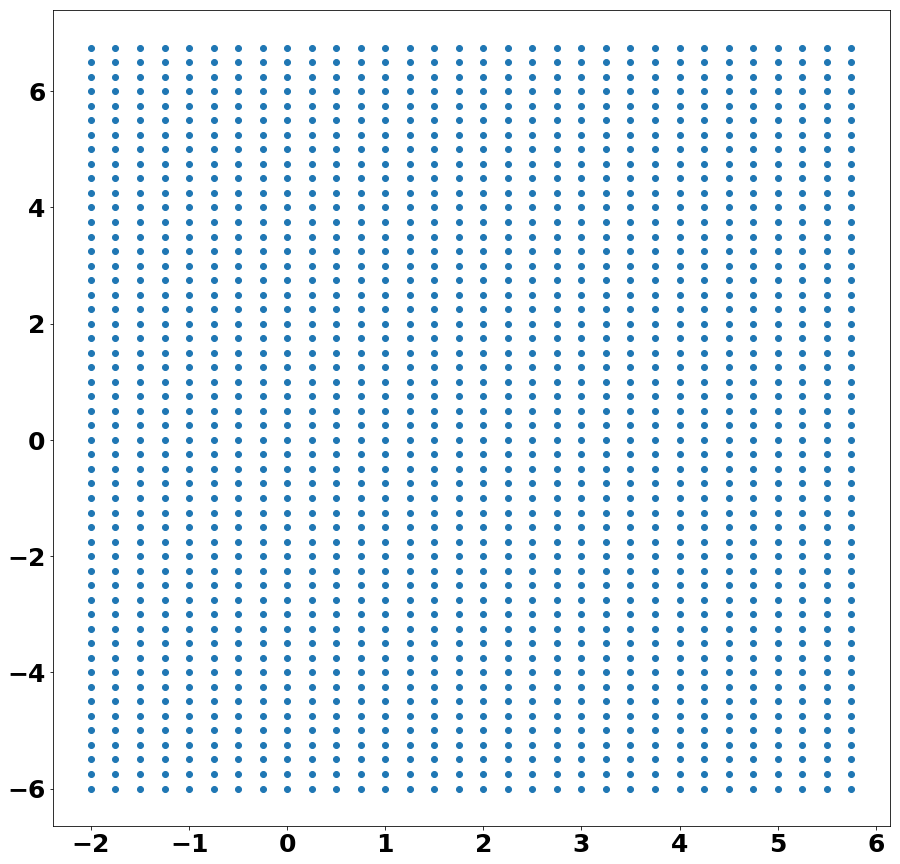

In [15]:
yy,xx = np.meshgrid(np.arange(-2,6,0.25),np.arange(-6,7,0.25))
plt.figure(figsize=(15,15))
plt.scatter(yy.ravel(),xx.ravel())